# Importing The Necessary Dependencies

In [1]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from PIL import Image
import glob
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from PIL import Image

# Loading and Splitting The Data

In [2]:
images = glob.glob("DATA++\\Mass\\*_FULL_*.png")
mask = glob.glob("DATA++\\Mass\\*_MASK_*.png")

In [3]:
print(images[:5])
print('-------------------')
print(mask[:5])

['DATA++\\Mass\\Mass-Test_P_00016_LEFT_CC_FULL_PRE.png', 'DATA++\\Mass\\Mass-Test_P_00016_LEFT_MLO_FULL_PRE.png', 'DATA++\\Mass\\Mass-Test_P_00017_LEFT_CC_FULL_PRE.png', 'DATA++\\Mass\\Mass-Test_P_00017_LEFT_MLO_FULL_PRE.png', 'DATA++\\Mass\\Mass-Test_P_00032_RIGHT_CC_FULL_PRE.png']
-------------------
['DATA++\\Mass\\Mass-Test_P_00016_LEFT_CC_MASK_1___PRE.png', 'DATA++\\Mass\\Mass-Test_P_00016_LEFT_MLO_MASK_1___PRE.png', 'DATA++\\Mass\\Mass-Test_P_00017_LEFT_CC_MASK_1___PRE.png', 'DATA++\\Mass\\Mass-Test_P_00017_LEFT_MLO_MASK_1___PRE.png', 'DATA++\\Mass\\Mass-Test_P_00032_RIGHT_CC_MASK_1___PRE.png']


In [4]:
data = pd.DataFrame({'images':images,'masks':mask})
data.head(9)

,images,masks
0,DATA++\Mass\Mass-Test_P_00016_LEFT_CC_FULL_PRE...,DATA++\Mass\Mass-Test_P_00016_LEFT_CC_MASK_1__...
1,DATA++\Mass\Mass-Test_P_00016_LEFT_MLO_FULL_PR...,DATA++\Mass\Mass-Test_P_00016_LEFT_MLO_MASK_1_...
2,DATA++\Mass\Mass-Test_P_00017_LEFT_CC_FULL_PRE...,DATA++\Mass\Mass-Test_P_00017_LEFT_CC_MASK_1__...
3,DATA++\Mass\Mass-Test_P_00017_LEFT_MLO_FULL_PR...,DATA++\Mass\Mass-Test_P_00017_LEFT_MLO_MASK_1_...
4,DATA++\Mass\Mass-Test_P_00032_RIGHT_CC_FULL_PR...,DATA++\Mass\Mass-Test_P_00032_RIGHT_CC_MASK_1_...
5,DATA++\Mass\Mass-Test_P_00032_RIGHT_MLO_FULL_P...,DATA++\Mass\Mass-Test_P_00032_RIGHT_MLO_MASK_1...
6,DATA++\Mass\Mass-Test_P_00037_RIGHT_CC_FULL_PR...,DATA++\Mass\Mass-Test_P_00037_RIGHT_CC_MASK_1_...
7,DATA++\Mass\Mass-Test_P_00037_RIGHT_MLO_FULL_P...,DATA++\Mass\Mass-Test_P_00037_RIGHT_MLO_MASK_1...
8,DATA++\Mass\Mass-Test_P_00056_LEFT_MLO_FULL_PR...,DATA++\Mass\Mass-Test_P_00056_LEFT_MLO_MASK_1_...


In [5]:
data.shape

(1592, 2)

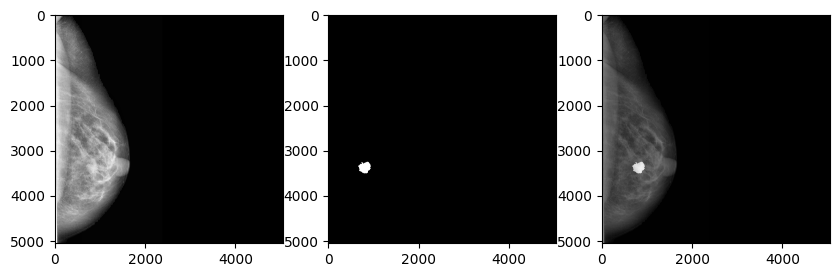

In [6]:
import cv2 
N=18
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
img=cv2.imread(data.images.iloc[N])
plt.imshow(img)
plt.subplot(1,3,2)
msk=cv2.imread(data.masks.iloc[N])
plt.imshow(msk)
plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(msk,alpha=0.5)

In [7]:
data_train,data_test=train_test_split(data,test_size=0.1)

data_train,data_val=train_test_split(data_train,test_size=0.2)

In [8]:
datagen = ImageDataGenerator(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest',
                            rescale=1./255)

In [9]:
image_train=datagen.flow_from_dataframe(data_train,  
                                    target_size=(256,256), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="images", 
                                    batch_size=8,
                                    class_mode=None
                                    
)
mask_train=datagen.flow_from_dataframe(data_train, 
                                    target_size=(256,256), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="masks", 
                                    batch_size=8,
                                    class_mode=None
)

Found 1145 validated image filenames.
Found 1145 validated image filenames.


In [10]:
image_validation=datagen.flow_from_dataframe(data_val,  
                                    target_size=(256,256), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="images", 
                                    batch_size=8,
                                    class_mode=None
)

mask_validation=datagen.flow_from_dataframe(data_val, 
                                    target_size=(256,256), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="masks", 
                                    batch_size=8,
                                    class_mode=None
)

Found 287 validated image filenames.
Found 287 validated image filenames.


In [11]:
train_gen=zip(image_train,mask_train)
valid_gen=zip(image_validation,mask_validation)

# Building The Model

In [12]:
def buildEncoder(input_shape = (256,256,3)):
    
    try:
            VGG16_ = keras.applications.VGG16(
                include_top=False,
                weights="imagenet",
                input_shape=input_shape,
            )

            # Get list of layer names for skip connections later
            layer_names = [layer.name for layer in VGG16_.layers]

            # Get layer outputs
            all_layer_outputs = [
                VGG16_.get_layer(layer_name).output for layer_name in layer_names
            ]

            # Create encoder model
            encoder_model = keras.Model(inputs=VGG16_.input, outputs=all_layer_outputs)

            # Freeze layers
            encoder_model.trainable = False

    except Exception as e:
            print((f"Unable to buildEncoder!\n{e}"))

    return encoder_model

In [13]:
 def buildUnet(input_shape=(256,256,3), dropout_training=True):
        
        try:
            # =============
            #  Input layer
            # =============

            unet_input = keras.Input(
                shape=input_shape, name="unet_input_layer"
            )

            x = unet_input

            # =========
            #  Encoder
            # =========

            encoder_model = buildEncoder(input_shape)
            all_encoder_layer_outputs = encoder_model(x)

            # Get final encoder output (this will be the input for the decoder)
            encoded_img = all_encoder_layer_outputs[-1]

            # Get outputs to be used for skip connections
            # (I know the specific layers to be used for skip connections)
            skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 5, 9, 13, 17]]

            # =========
            #  Decoder
            # =========

            decoder_filters = int(encoded_img.shape[-1])

            # ------------------------------------------
            # Block 5: 7x7 -> 14x14
            #  - `encoded_img` as initial input for decoder
            x = keras.layers.Conv2DTranspose(
                name="block5_up_convT",
                filters=decoder_filters,
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(encoded_img)

            x = keras.layers.Concatenate(name="block5_up_concat", axis=-1)(
                [x, skip_outputs[4]]
            )

            x = keras.layers.Dropout(
                name="block5_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block5_up_conv3",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv2",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv1",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 4: 14x14 -> 28x28
            x = keras.layers.Conv2DTranspose(
                name="block4_up_convT",
                filters=decoder_filters,
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(x)

            x = keras.layers.Concatenate(name="block4_up_concat", axis=-1)(
                [x, skip_outputs[3]]
            )

            x = keras.layers.Dropout(
                name="block4_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block4_up_conv3",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv2",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv1",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 3: 28x28 -> 56x56
            x = keras.layers.Conv2DTranspose(
                name="block3_up_convT",
                filters=int(decoder_filters / 2),
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(x)

            x = keras.layers.Concatenate(name="block3_up_concat", axis=-1)(
                [x, skip_outputs[2]]
            )

            x = keras.layers.Dropout(
                name="block3_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block3_up_conv3",
                filters=int(decoder_filters / 2),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv2",
                filters=int(decoder_filters / 2),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv1",
                filters=int(decoder_filters / 2),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 2: 56x56 -> 112x112
            x = keras.layers.Conv2DTranspose(
                name="block2_up_convT",
                filters=int(decoder_filters / 4),
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(x)

            x = keras.layers.Concatenate(name="block2_up_concat", axis=-1)(
                [x, skip_outputs[1]]
            )

            x = keras.layers.Dropout(
                name="block2_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block2_up_conv2",
                filters=int(decoder_filters / 4),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block2_up_conv1",
                filters=int(decoder_filters / 4),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 1: 112x112 -> 224x224
            x = keras.layers.Conv2DTranspose(
                name="block1_up_convT",
                filters=int(decoder_filters / 8),
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(x)

            x = keras.layers.Concatenate(name="block1_up_concat", axis=-1)(
                [x, skip_outputs[0]]
            )

            x = keras.layers.Dropout(
                name="block1_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block1_up_conv2",
                filters=int(decoder_filters / 8),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            decoded_img = keras.layers.Conv2D(
                name="block1_up_conv1",
                filters=int(decoder_filters / 8),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Final conv layer
            final_img = keras.layers.Conv2D(
                name="final_up_conv",
                filters=1,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="sigmoid",
            )(decoded_img)

            # ======
            #  Unet
            # ======

            unet = keras.Model(inputs=unet_input, outputs=final_img, name="Unet_VGG16")
            
            return unet
        
        except Exception as e:
            print((f"Unable to buildUnet!\n{e}"))

        

In [14]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

In [27]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='dice_coef', patience=10)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='vgg16_checkpoint_256.h5', monitor='dice_coef', save_best_only=True)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2, patience=2)

In [16]:
model = buildUnet(input_shape=(256, 256, 3))

In [17]:
model.summary()

Model: "Unet_VGG16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 unet_input_layer (InputLayer)  [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 256, 256, 3  14714688    ['unet_input_layer[0][0]']       
                                ),                                                                
                                 (None, 256, 256, 6                                               
                                4),                                                               
                                 (None, 256, 256, 6                                      

                                                                                                  
 block3_up_conv2 (Conv2D)       (None, 64, 64, 256)  590080      ['block3_up_conv3[0][0]']        
                                                                                                  
 block3_up_conv1 (Conv2D)       (None, 64, 64, 256)  590080      ['block3_up_conv2[0][0]']        
                                                                                                  
 block2_up_convT (Conv2DTranspo  (None, 128, 128, 12  295040     ['block3_up_conv1[0][0]']        
 se)                            8)                                                                
                                                                                                  
 block2_up_concat (Concatenate)  (None, 128, 128, 25  0          ['block2_up_convT[0][0]',        
                                6)                                'model[0][5]']                  
          

In [18]:
model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[dice_coef,'accuracy'])

In [19]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    validation_steps=len(data_val) /8,
    steps_per_epoch=len(data_train) /8,
    callbacks=[early_stopping_callback,reduce_lr_callback]
)

Epoch 1/30


C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


143/143 [==============================] - 510s 3s/step - loss: 0.8369 - dice_coef: 0.2061 - accuracy: 0.9904 - val_loss: 0.6924 - val_dice_coef: 0.3423 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 2/30
143/143 [==============================] - 351s 2s/step - loss: 0.6755 - dice_coef: 0.3603 - accuracy: 0.9943 - val_loss: 0.6470 - val_dice_coef: 0.3840 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 3/30
143/143 [==============================] - 350s 2s/step - loss: 0.6172 - dice_coef: 0.4109 - accuracy: 0.9952 - val_loss: 0.7141 - val_dice_coef: 0.3241 - val_accuracy: 0.9959 - lr: 0.0010
Epoch 4/30
143/143 [==============================] - 349s 2s/step - loss: 0.6370 - dice_coef: 0.3965 - accuracy: 0.9951 - val_loss: 0.6792 - val_dice_coef: 0.3627 - val_accuracy: 0.9956 - lr: 0.0010
Epoch 5/30
143/143 [==============================] - 349s 2s/step - loss: 0.6276 - dice_coef: 0.4023 - accuracy: 0.9949 - val_loss: 0.6156 - val_dice_coef: 0.4134 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 6/30


In [20]:
eval_results = model.evaluate(valid_gen, steps=len(data_val) /8, verbose=1)

35/35 [==============================] - 64s 2s/step - loss: 0.5966 - dice_coef: 0.4294 - accuracy: 0.9957


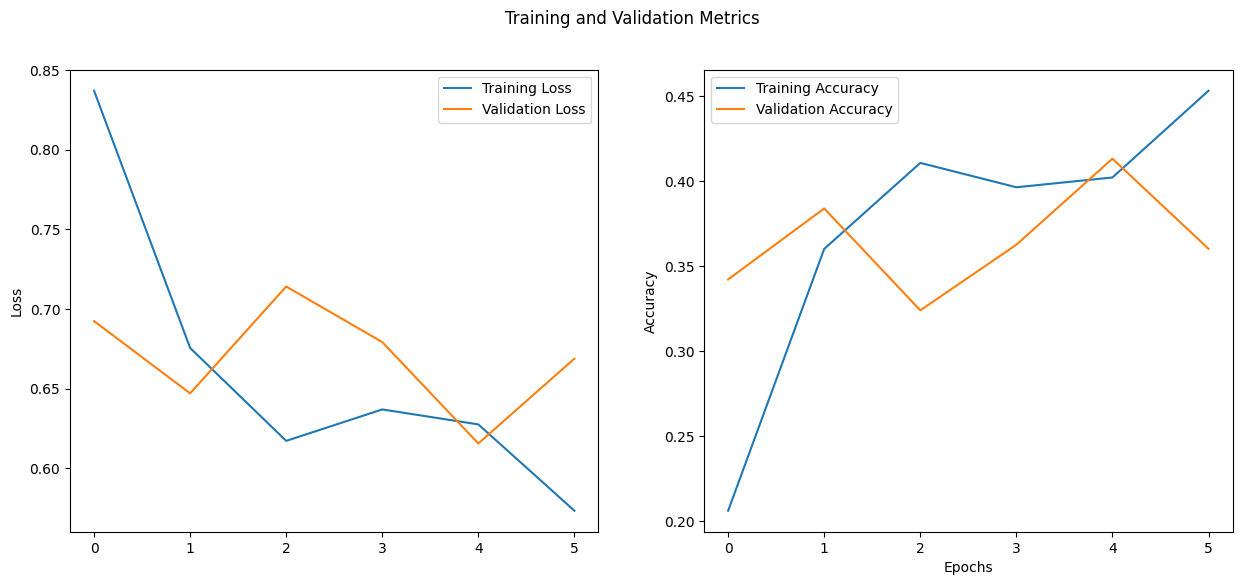

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 6))

# Plotting the training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting the training and validation accuracy
ax2.plot(history.history['dice_coef'], label='Training Accuracy')
ax2.plot(history.history['val_dice_coef'], label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.suptitle('Training and Validation Metrics')
plt.show()

1/1 [==============================] - 0s 291ms/step


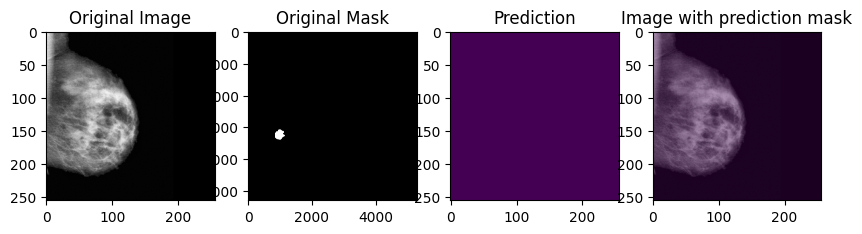

1/1 [==============================] - 0s 20ms/step


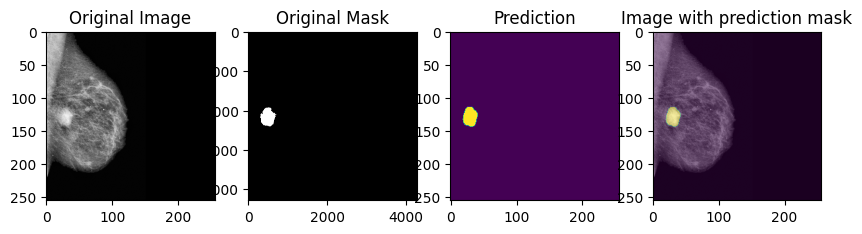

1/1 [==============================] - 0s 21ms/step


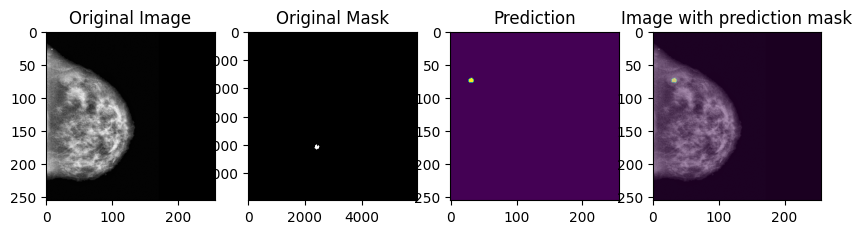

1/1 [==============================] - 0s 20ms/step


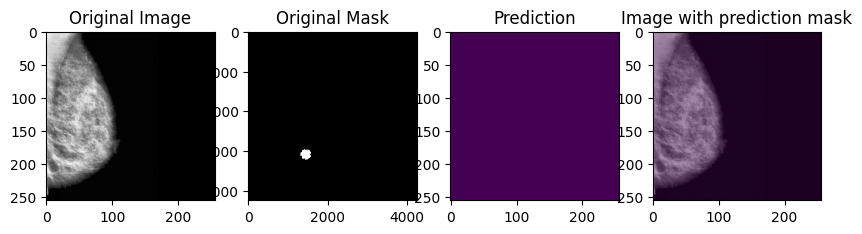

1/1 [==============================] - 0s 19ms/step


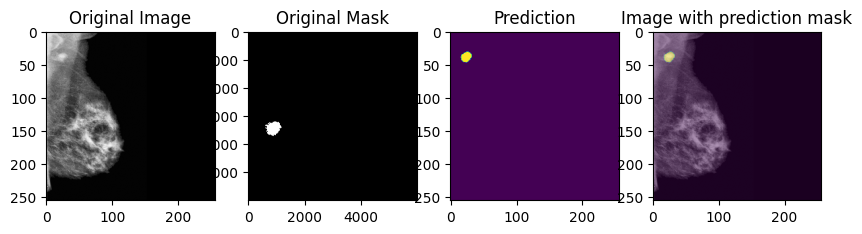

1/1 [==============================] - 0s 20ms/step


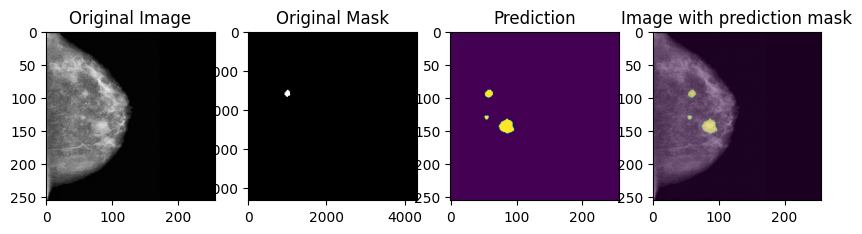

1/1 [==============================] - 0s 20ms/step


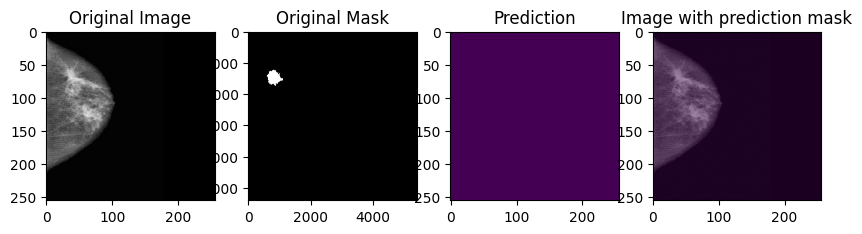

1/1 [==============================] - 0s 22ms/step


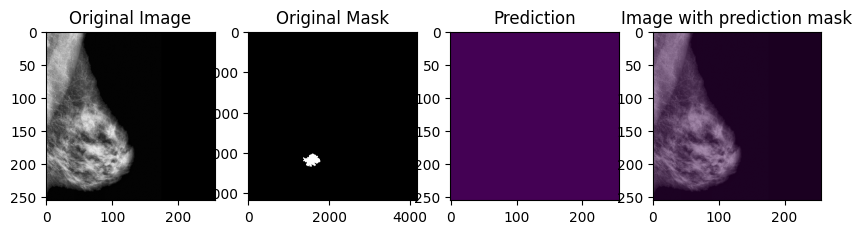

1/1 [==============================] - 0s 19ms/step


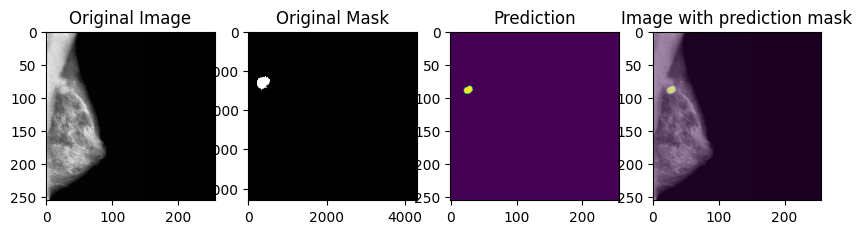

1/1 [==============================] - 0s 21ms/step


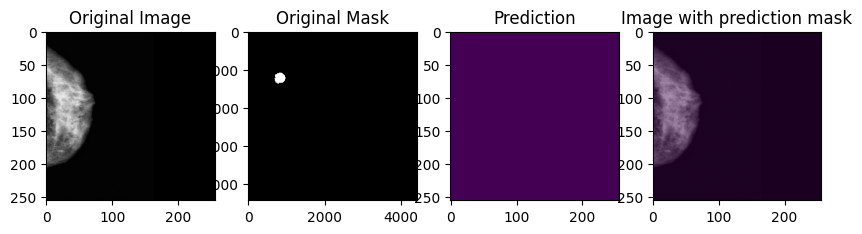

In [22]:
import cv2
for i in range(10):
    index=np.random.randint(1,len(data_test.index))
    img = cv2.imread(data_test['images'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(cv2.imread(data_test['masks'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(img))
    plt.imshow(np.squeeze(pred)>.5,alpha=0.4)
    plt.title('Image with prediction mask')
    plt.show()

In [23]:
model.save('vgg16_model_6_epochs.h5')

In [25]:
model0 = buildUnet(input_shape=(256, 256, 3))

In [26]:
model0.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[dice_coef,'accuracy'])

In [29]:
history = model0.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    validation_steps=len(data_val) /8,
    steps_per_epoch=len(data_train) /8,
    callbacks=[early_stopping_callback,checkpoint_callback,reduce_lr_callback]
)

Epoch 1/30


C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


143/143 [==============================] - 523s 4s/step - loss: 0.9482 - dice_coef: 0.1093 - accuracy: 0.9870 - val_loss: 0.7310 - val_dice_coef: 0.2998 - val_accuracy: 0.9950 - lr: 0.0010
Epoch 2/30
143/143 [==============================] - 520s 4s/step - loss: 0.6442 - dice_coef: 0.3891 - accuracy: 0.9945 - val_loss: 0.6370 - val_dice_coef: 0.4010 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 3/30
143/143 [==============================] - 518s 4s/step - loss: 0.6200 - dice_coef: 0.4090 - accuracy: 0.9952 - val_loss: 0.6672 - val_dice_coef: 0.3655 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 4/30
143/143 [==============================] - 519s 4s/step - loss: 0.5711 - dice_coef: 0.4505 - accuracy: 0.9954 - val_loss: 0.6425 - val_dice_coef: 0.3877 - val_accuracy: 0.9957 - lr: 2.0000e-04
Epoch 5/30
143/143 [==============================] - 519s 4s/step - loss: 0.5593 - dice_coef: 0.4648 - accuracy: 0.9955 - val_loss: 0.5858 - val_dice_coef: 0.4391 - val_accuracy: 0.9954 - lr: 2.0000e-04
Epo

In [34]:
model0.save('vgg16_model_11_epochs.h5')

In [31]:
eval_results = model0.evaluate(valid_gen, steps=len(data_val) /8, verbose=1)

35/35 [==============================] - 63s 2s/step - loss: 0.5737 - dice_coef: 0.4515 - accuracy: 0.9953


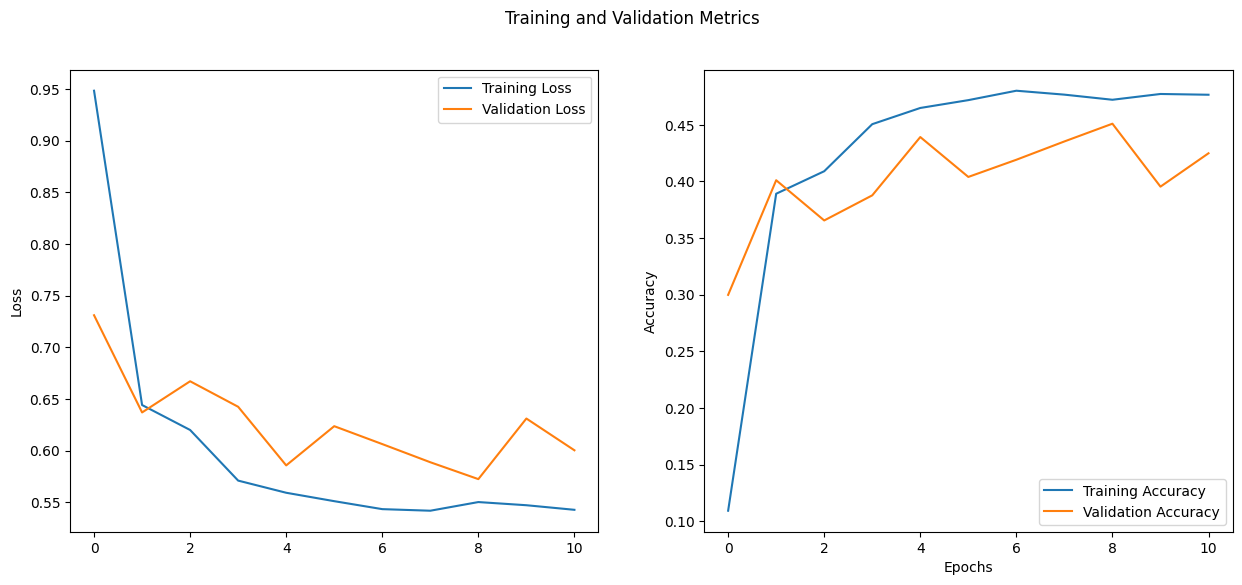

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 6))

# Plotting the training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting the training and validation accuracy
ax2.plot(history.history['dice_coef'], label='Training Accuracy')
ax2.plot(history.history['val_dice_coef'], label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.suptitle('Training and Validation Metrics')
plt.show()

1/1 [==============================] - 0s 260ms/step


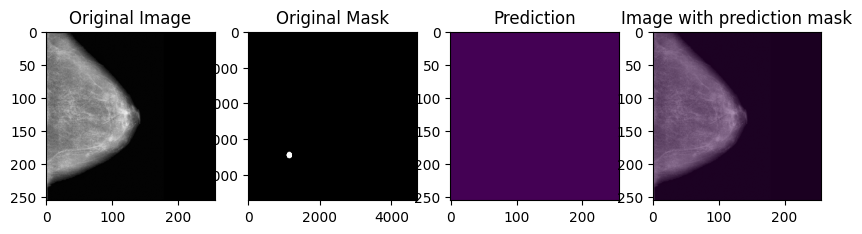

1/1 [==============================] - 0s 29ms/step


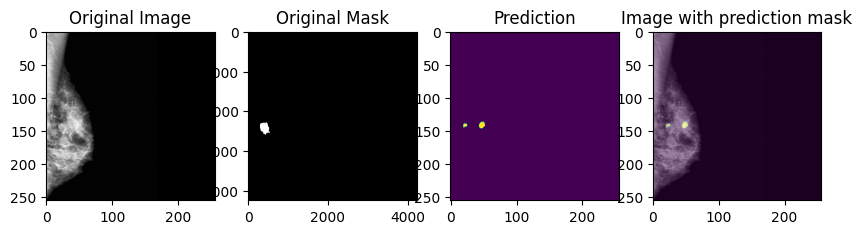

1/1 [==============================] - 0s 26ms/step


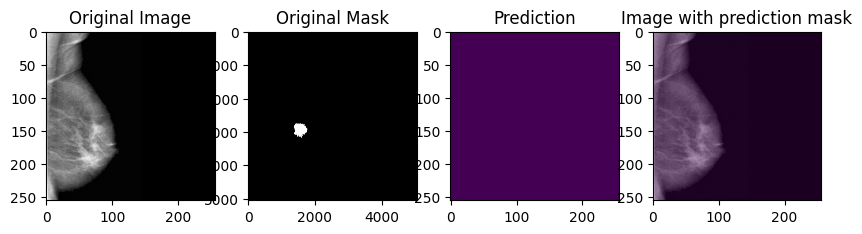

1/1 [==============================] - 0s 24ms/step


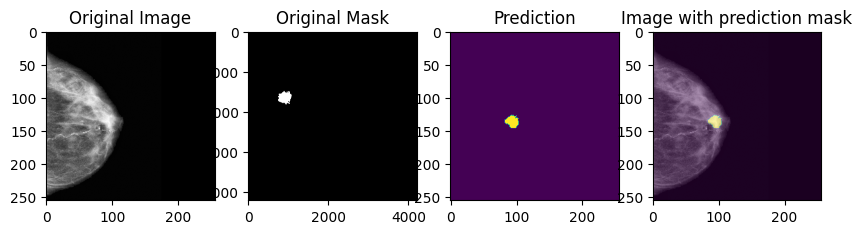

1/1 [==============================] - 0s 22ms/step


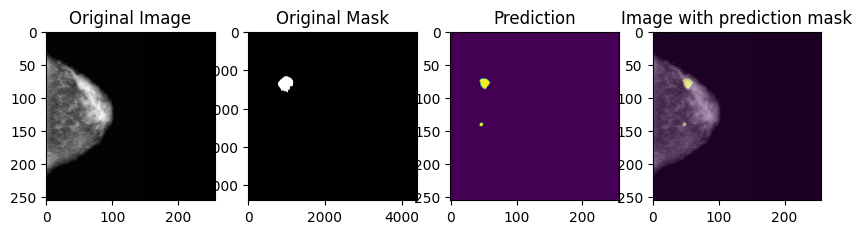

1/1 [==============================] - 0s 20ms/step


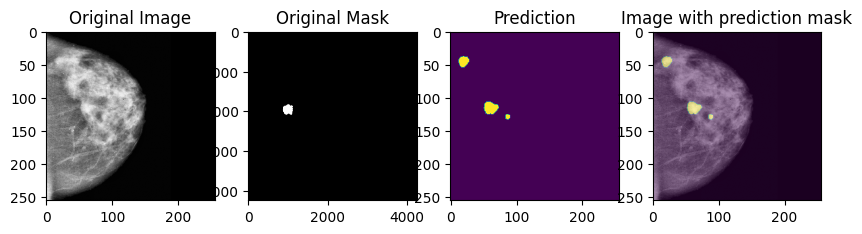

1/1 [==============================] - 0s 22ms/step


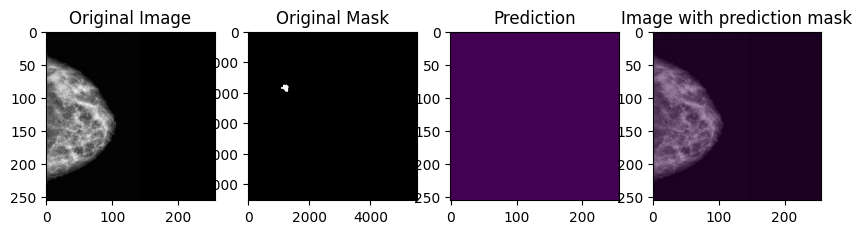

1/1 [==============================] - 0s 22ms/step


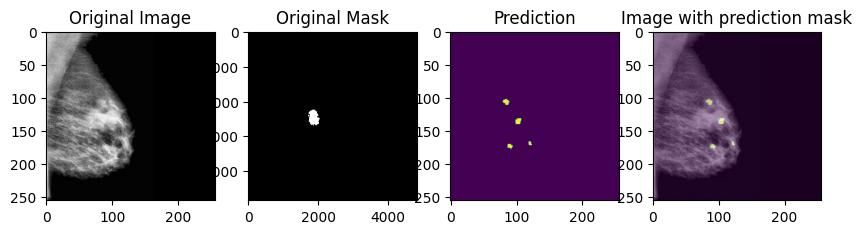

1/1 [==============================] - 0s 18ms/step


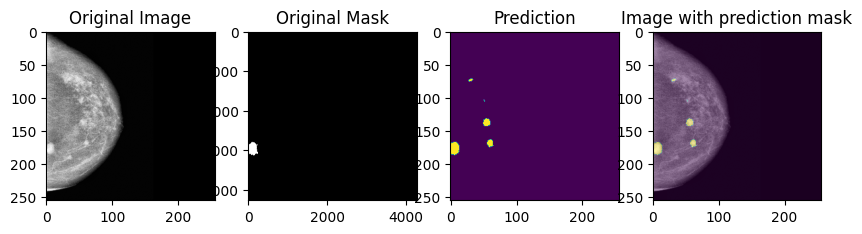

1/1 [==============================] - 0s 21ms/step


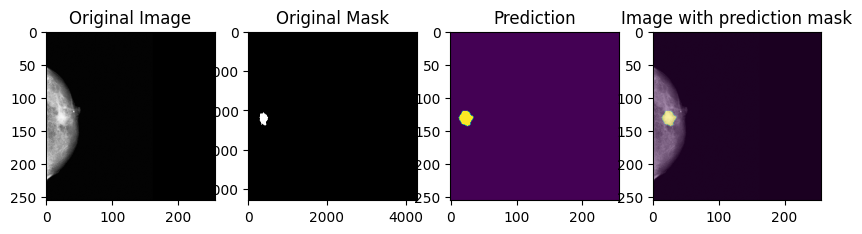

In [33]:
import cv2
for i in range(10):
    index=np.random.randint(1,len(data_test.index))
    img = cv2.imread(data_test['images'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model0.predict(img)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(cv2.imread(data_test['masks'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(img))
    plt.imshow(np.squeeze(pred)>.5,alpha=0.4)
    plt.title('Image with prediction mask')
    plt.show()

In [35]:
model0.save('vgg16_model_11_e.h5')

In [2]:
from tensorflow.keras.models import load_model
model = load_model('vgg16_checkpoint_256.h5')

ValueError: Unknown loss function: bce_dice_loss. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.